In [1]:
import numpy as np
import os
import sep
import re
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.cm as mcm
import matplotlib.colors as mcol
import scipy.stats as sts
from matplotlib import ticker
import numpy.ma as nma
from sklearn import linear_model
from scipy.interpolate import CubicSpline
from sklearn.feature_selection import mutual_info_regression
#import fitsio
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import ManualInterval,LogStretch
import statmorph
from data_get import *
from make_rgb import *

plt.rcParams['figure.figsize'] = [8., 8.]
plt.rcParams["axes.linewidth"]  = 2
plt.rcParams["xtick.major.size"]  = 8
plt.rcParams["xtick.minor.size"]  = 3
plt.rcParams["ytick.major.size"]  = 8
plt.rcParams["ytick.minor.size"]  = 3
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams.update({'font.size': 24})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams["mathtext.default"] = 'rm'
plt.rcParams["mathtext.fontset"] = 'cm'

In [2]:
sources = pd.read_csv('v1saga_dwarfs.csv')
print(np.shape(sources))
#download_cutout(sources)

morph_all = np.load('morph_array.npy')
print(np.shape(morph_all))

sersic_all = np.load('sersic_array.npy')
print(np.shape(sersic_all))


(6337, 26)
(4886, 4, 12)


In [25]:
rd2deg = (180*3600)/np.pi

#mst = sources['logM'].iloc[morph_all[high_snr,i,0]]
#zspec = sources['zspec'].iloc[morph_all[high_snr,i,0]]
#res = 1e6*(0.262*cosmo.comoving_distance(zspec).value)/rd2deg

channels = {'g':mcm.cividis,'r':mcm.viridis,'i':mcm.inferno,'z':mcm.Greys_r}
griz_col = ['tab:blue','tab:green','tab:orange','tab:red']
positions = [0, 1, 2, 3]
labels = [r'${\it g}$', r'${\it r}$', r'${\it i}$', r'${\it z}$']

npr = {1:[[0.4,0.6],r'${\it Gini}$'],2:[[-2,-1],r'$M_{20}$'],5:[[2,3.5],r'$Concentration$'],6:[[-0.4,0.4],r'$Asymmetry$'],7:[[-0.1,0.1],r'$Smoothness$']}
ser = {0:[[0.0,5],r'${\it Sersic\ n}$'],1:[[0,20],r'$R_{0.5}$']}
filt_cmap = [mcm.cividis_r,mcm.viridis_r,mcm.inferno_r,mcm.Greys]

NameError: name 'sersic_all' is not defined

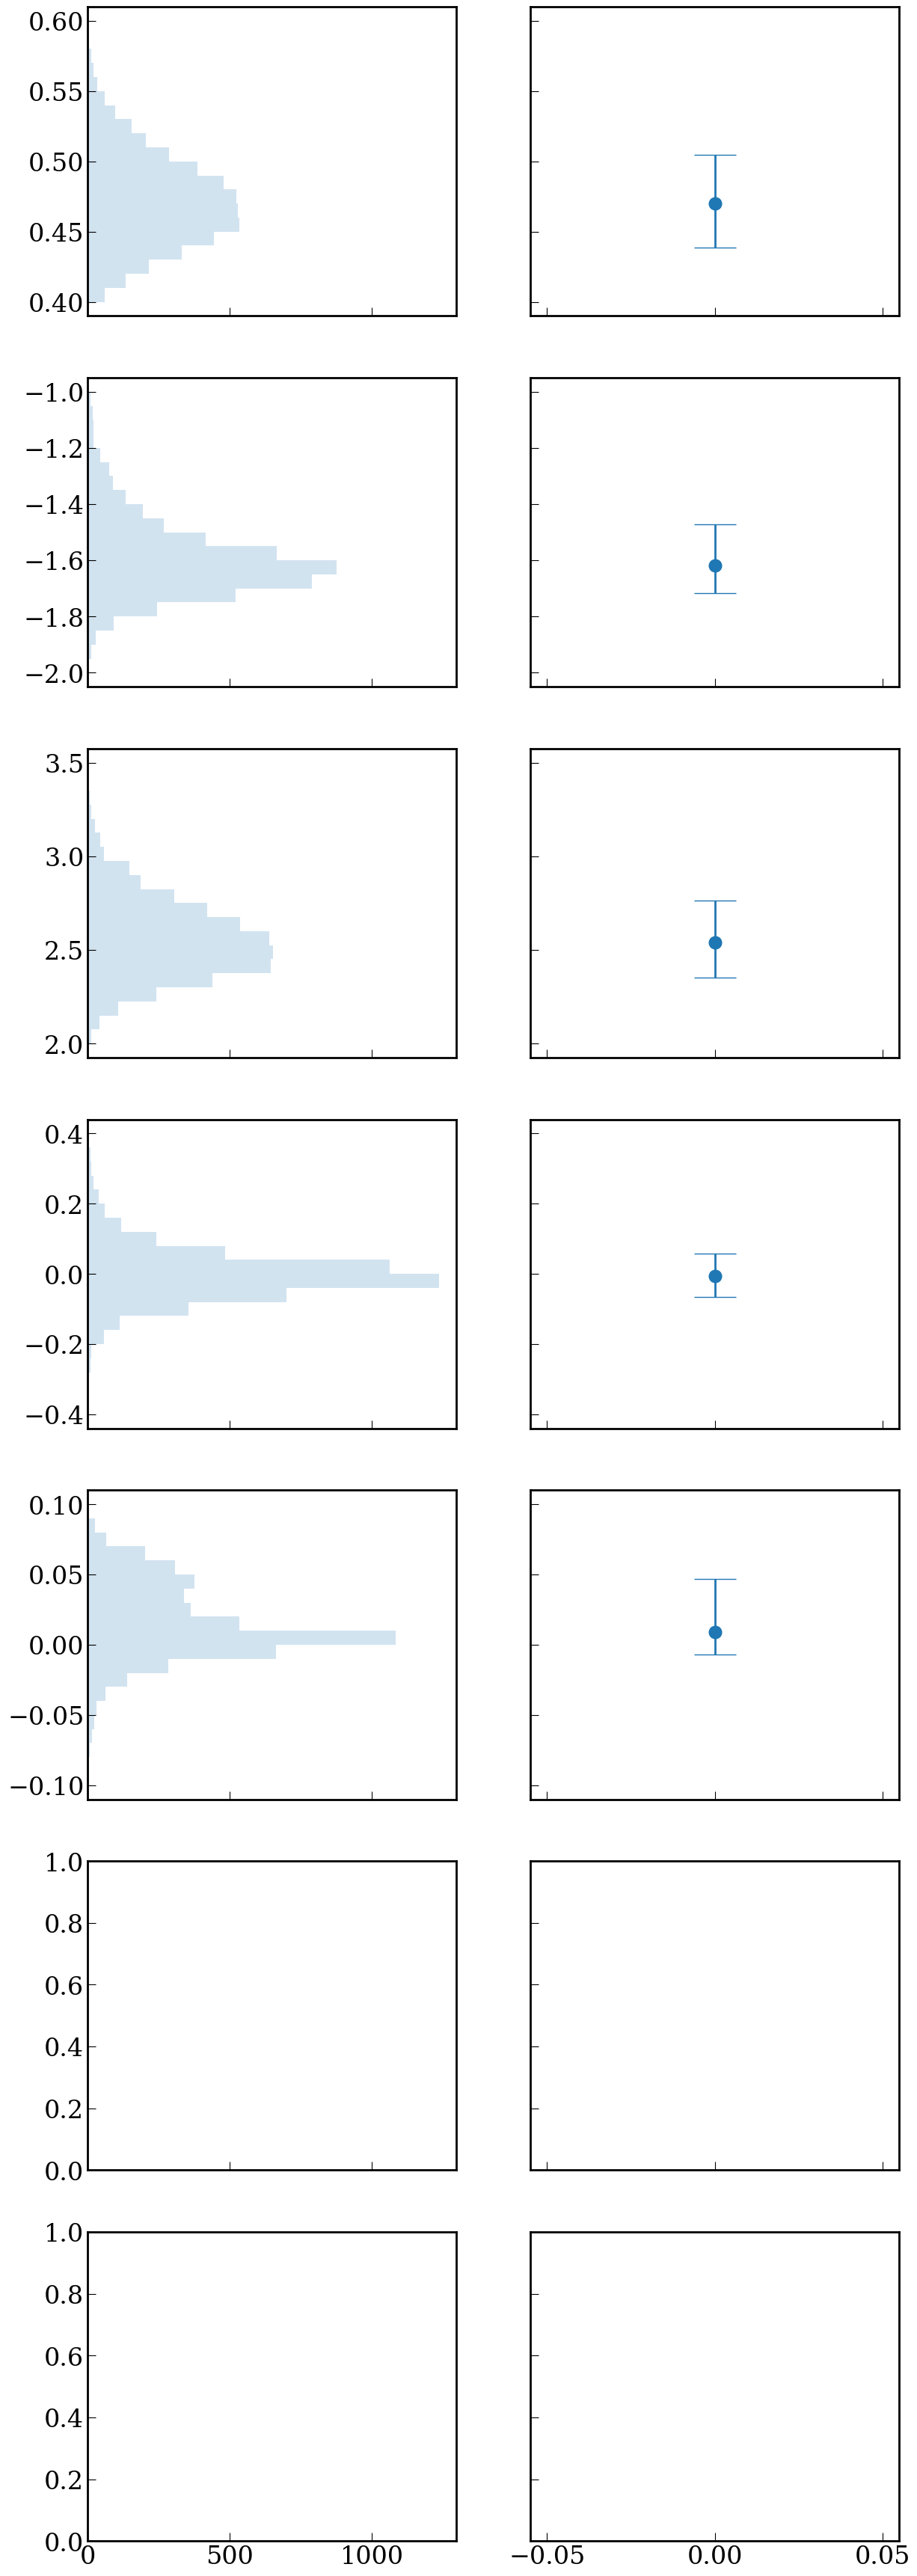

In [26]:
fig,ax=plt.subplots(7,2,figsize=(14,44),sharex='col',sharey='row')

median_arr = np.zeros((4,5))

for i in range(4):
    #print(morph_arr[:,-1])
    selc = np.where((morph_all[:,i,9]==0)&(morph_all[:,i,10]>=2))[0]
    if i==2: selc = np.where((morph_all[:,i,9]==0)&(morph_all[:,i,10]>=2)&(~np.isnan(sources['m_i0'].iloc[morph_all[:,i,0]])))[0]

    for j,key in enumerate(npr):
        ax[j,0].hist(morph_all[selc,i,key],bins=np.linspace(npr[key][0][0],npr[key][0][1],21),alpha=0.2,color=griz_col[i],orientation='horizontal')

        median_arr[i,j] = np.median(morph_all[selc,i,key])
        ax[j,1].errorbar(i,median_arr[i,j],yerr=np.array([median_arr[i,j]-np.percentile(morph_all[selc,i,key],16),np.percentile(morph_all[selc,i,key],84)-median_arr[i,j]]).reshape(2,1),color=griz_col[i],marker='o',markersize=12,elinewidth=2,capsize=20)

    for j,key in enumerate(ser):
        ax[j+5,0].hist(sersic_all[selc,i,key],bins=np.linspace(ser[key][0][0],ser[key][0][1],21),alpha=0.2,color=griz_col[i],orientation='horizontal')

        median_arr[i,j] = np.median(sersic_all[selc,i,key])
        ax[j+5,1].errorbar(i,median_arr[i,j],yerr=np.array([median_arr[i,j]-np.percentile(sersic_all[selc,i,key],16),np.percentile(sersic_all[selc,i,key],84)-median_arr[i,j]]).reshape(2,1),color=griz_col[i],marker='o',markersize=12,elinewidth=2,capsize=20)
    
ax[-1,1].xaxis.set_major_locator(ticker.FixedLocator(positions))
ax[-1,1].xaxis.set_major_formatter(ticker.FixedFormatter(labels))

ax[0,0].set_ylabel(r'${\it Gini}$',fontsize=36)
ax[1,0].set_ylabel(r'$M_{20}$',fontsize=36)
ax[2,0].set_ylabel(r'$Concentration$',fontsize=36)
ax[3,0].set_ylabel(r'$Asymmetry$',fontsize=36)
ax[4,0].set_ylabel(r'$Smoothness$',fontsize=36)
ax[5,0].set_ylabel(r'$Sersic$',fontsize=36)
ax[6,0].set_ylabel(r'$R^{Sersic}_{0.5}$',fontsize=36)

plt.subplots_adjust(hspace=0.0,wspace=0.0)
plt.savefig('NPdistributions.pdf',bbox_inches='tight')

Text(0, 0.5, '${\\rm MI\\ Score}$')

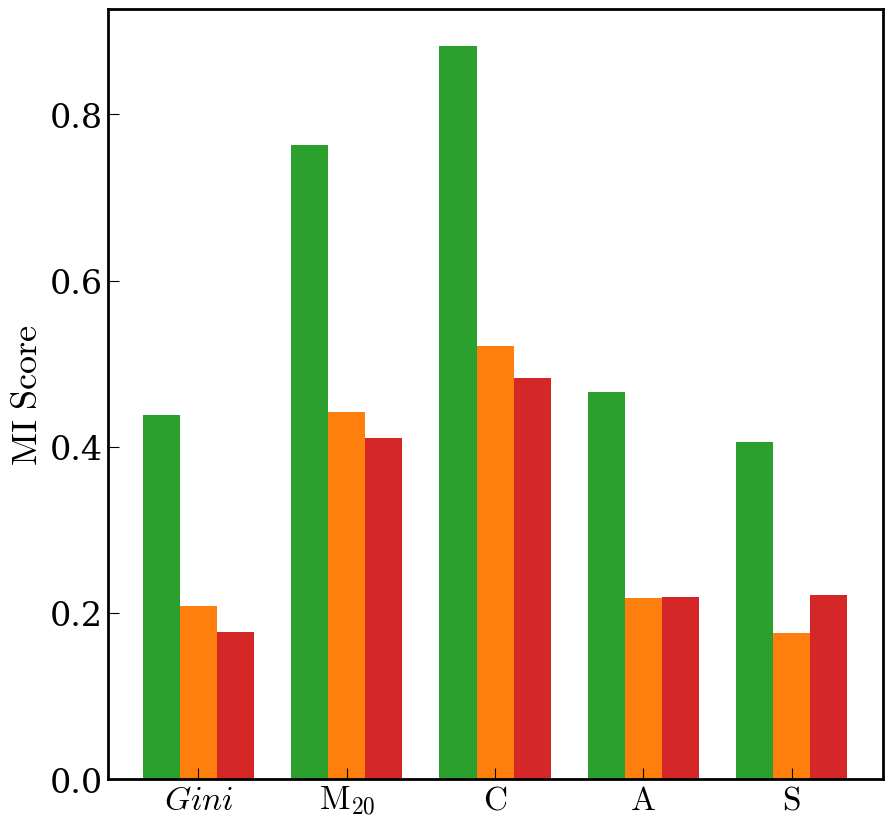

In [8]:
fig,ax=plt.subplots(figsize=(10,10))

mi_scores = np.ones((5,3))
param_pos = np.arange(5)
param_label = []

for i,k in enumerate(param):
        mi_scores[i,:] = mutual_info_regression(morph_all[selc,1:,k], morph_all[selc,0,k])
        param_label.append(param[k][1])

width = 0.25  # the width of the bars

multiplier = 0
    
for j in range(3):
    offset = width * multiplier
    ax.bar(param_pos + offset, mi_scores[:,j], width,color=griz_col[j+1])
    multiplier += 1    
ax.set_xticks(param_pos+width, labels=param_label)
ax.set_ylabel(r'${\rm MI\ Score}$',fontsize=26)




[0.24628508 0.15751014 0.05707574 0.14211465]
[0.28463336 0.27485514 0.13943593 0.22067406]
[0.17441107 0.18411401 0.13464481 0.18841828]
[0.03557407 0.05857876 0.02211257 0.        ]
[0.00480893 0.02779673 0.04538878 0.05470123]


Text(0, 0.5, '${\\rm MI\\ Score}$')

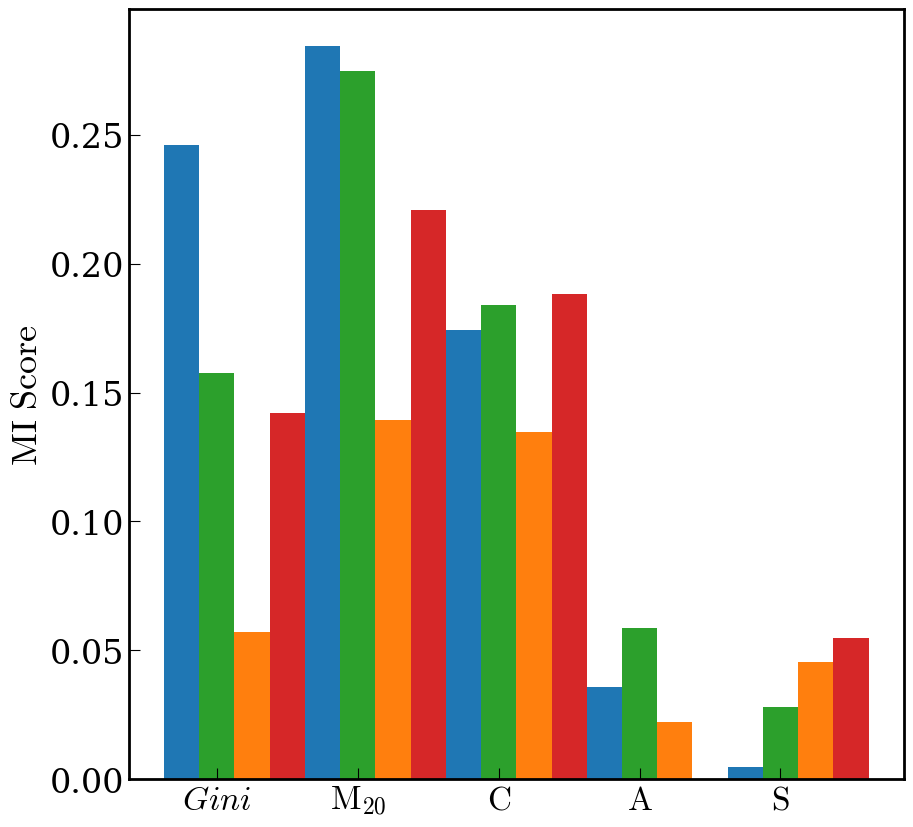

In [103]:
fig,ax=plt.subplots(figsize=(10,10))

mst = sources['n'].iloc[morph_all[selc,0,0]]

mi_scores = np.ones((5,4))
param_pos = np.arange(5)
param_label = []

for i,k in enumerate(param):
        mi_scores[i,:] = mutual_info_regression(morph_all[selc,:,k], mst)
        print(mi_scores[i,:])
        param_label.append(param[k][1])

width = 0.25  # the width of the bars

multiplier = 0
    
for j in range(4):
    offset = width * multiplier
    ax.bar(param_pos + offset, mi_scores[:,j], width,color=griz_col[j])
    multiplier += 1    
    
ax.set_xticks(param_pos+width, labels=param_label)
ax.set_ylabel(r'${\rm MI\ Score}$',fontsize=26)




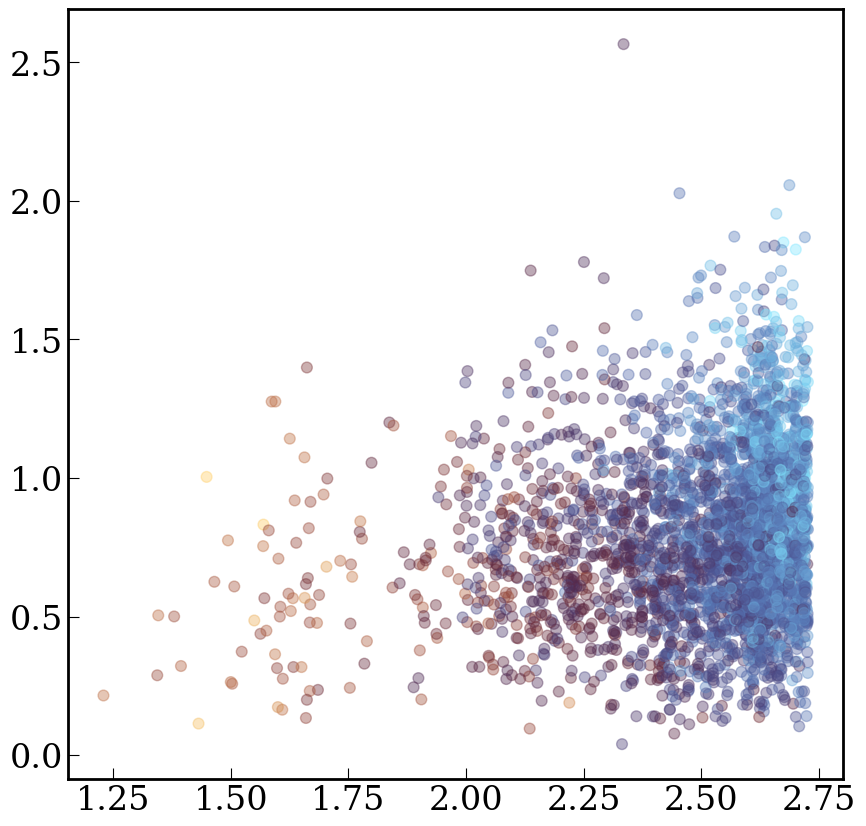

In [39]:
fig,ax=plt.subplots(figsize=(10,10),sharey='row')


ax.scatter(np.log10(res),np.log10(morph_all[selc,i,10]),alpha=0.4,c=mst,s=60,cmap=mcm.managua,vmin=6,vmax=10)
#ax.scatter(rmag,sfbr,alpha=0.4,s=60,c='none',edgecolor='black')


3522 3522
3522 3522
3522 3522
3522 3522


<>:25: SyntaxWarning: invalid escape sequence '\i'
<>:25: SyntaxWarning: invalid escape sequence '\i'
/var/folders/_b/znph9d951ln009y69l1s4tn00000gn/T/ipykernel_92873/2874637516.py:25: SyntaxWarning: invalid escape sequence '\i'
  ax[0].set_xlabel(r'${\it Gini}$',fontsize=36)


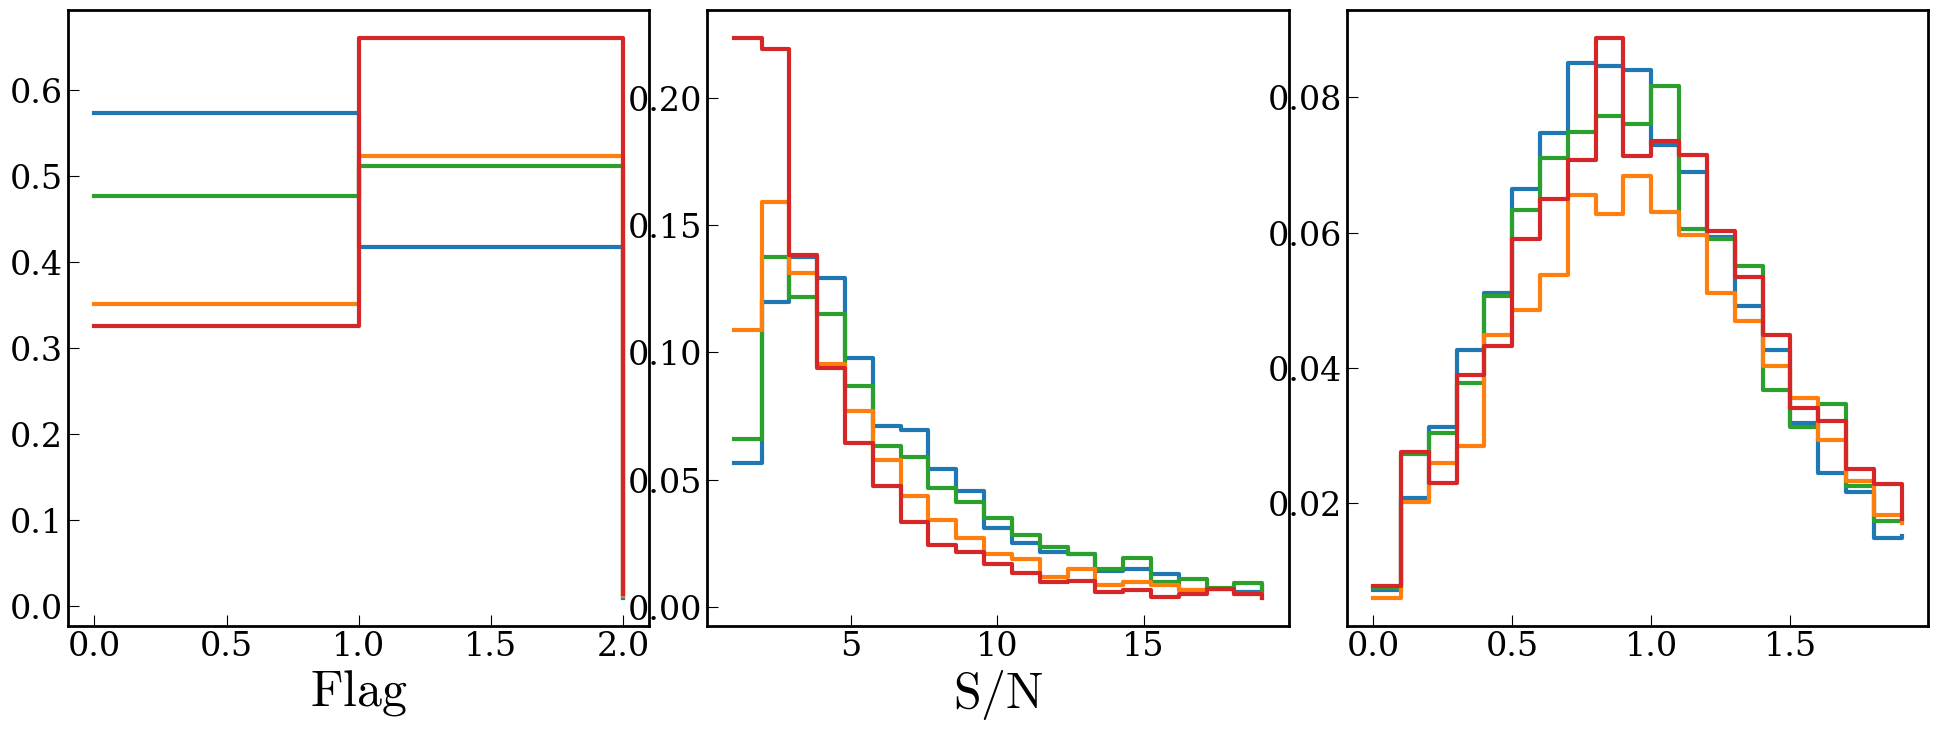

In [7]:
fig,ax=plt.subplots(1,3,figsize=(24,8))

griz_col = ['tab:blue','tab:green','tab:orange','tab:red']

for i in range(4):
    print(len(morph_all[:,i,9]),len(morph_all[:,i,10]))
    #print(morph_arr[:,-1])
    hist, bin_edg = np.histogram(morph_all[:,i,9], bins=np.arange(0,4,1))
    
    ax[0].step(bin_edg[:-1],hist/len(morph_all[:,i,9]),where='post',lw=3,color=griz_col[i])

    hist, bin_edg = np.histogram(morph_all[:,i,10], bins=np.linspace(1,20,21))
    
    ax[1].step(bin_edg[:-1],hist/len(morph_all[:,i,10]),where='post',lw=3,color=griz_col[i])
    #ax[i,2].hist(morph_all[:,i,10],bins=np.linspace(0,1,26),alpha=0.4,color=griz_col[i])

    hist, bin_edg = np.histogram(morph_all[:,i,11], bins=np.linspace(0,2,21))
    
    ax[2].step(bin_edg[:-1],hist/len(morph_all[:,i,11]),where='post',lw=3,color=griz_col[i])

ax[0].set_xlabel(r'${Flag}$',fontsize=36)
ax[1].set_xlabel(r'$S/N$',fontsize=36)
#ax[3,2].set_xlabel(r'$Segm\ Frac$',fontsize=36)
'''
ax[0].set_xlabel(r'${\it Gini}$',fontsize=36)
ax[1].set_xlabel(r'$M_{20}$',fontsize=36)
ax[2].set_xlabel(r'$Concentration$',fontsize=36)
ax[3].set_xlabel(r'$Asymmetry$',fontsize=36)
ax[4].set_xlabel(r'$Smoothness$',fontsize=36)
'''
plt.subplots_adjust(hspace=0.0,wspace=0.1)
#plt.savefig('NPdistributions.pdf',bbox_inches='tight')

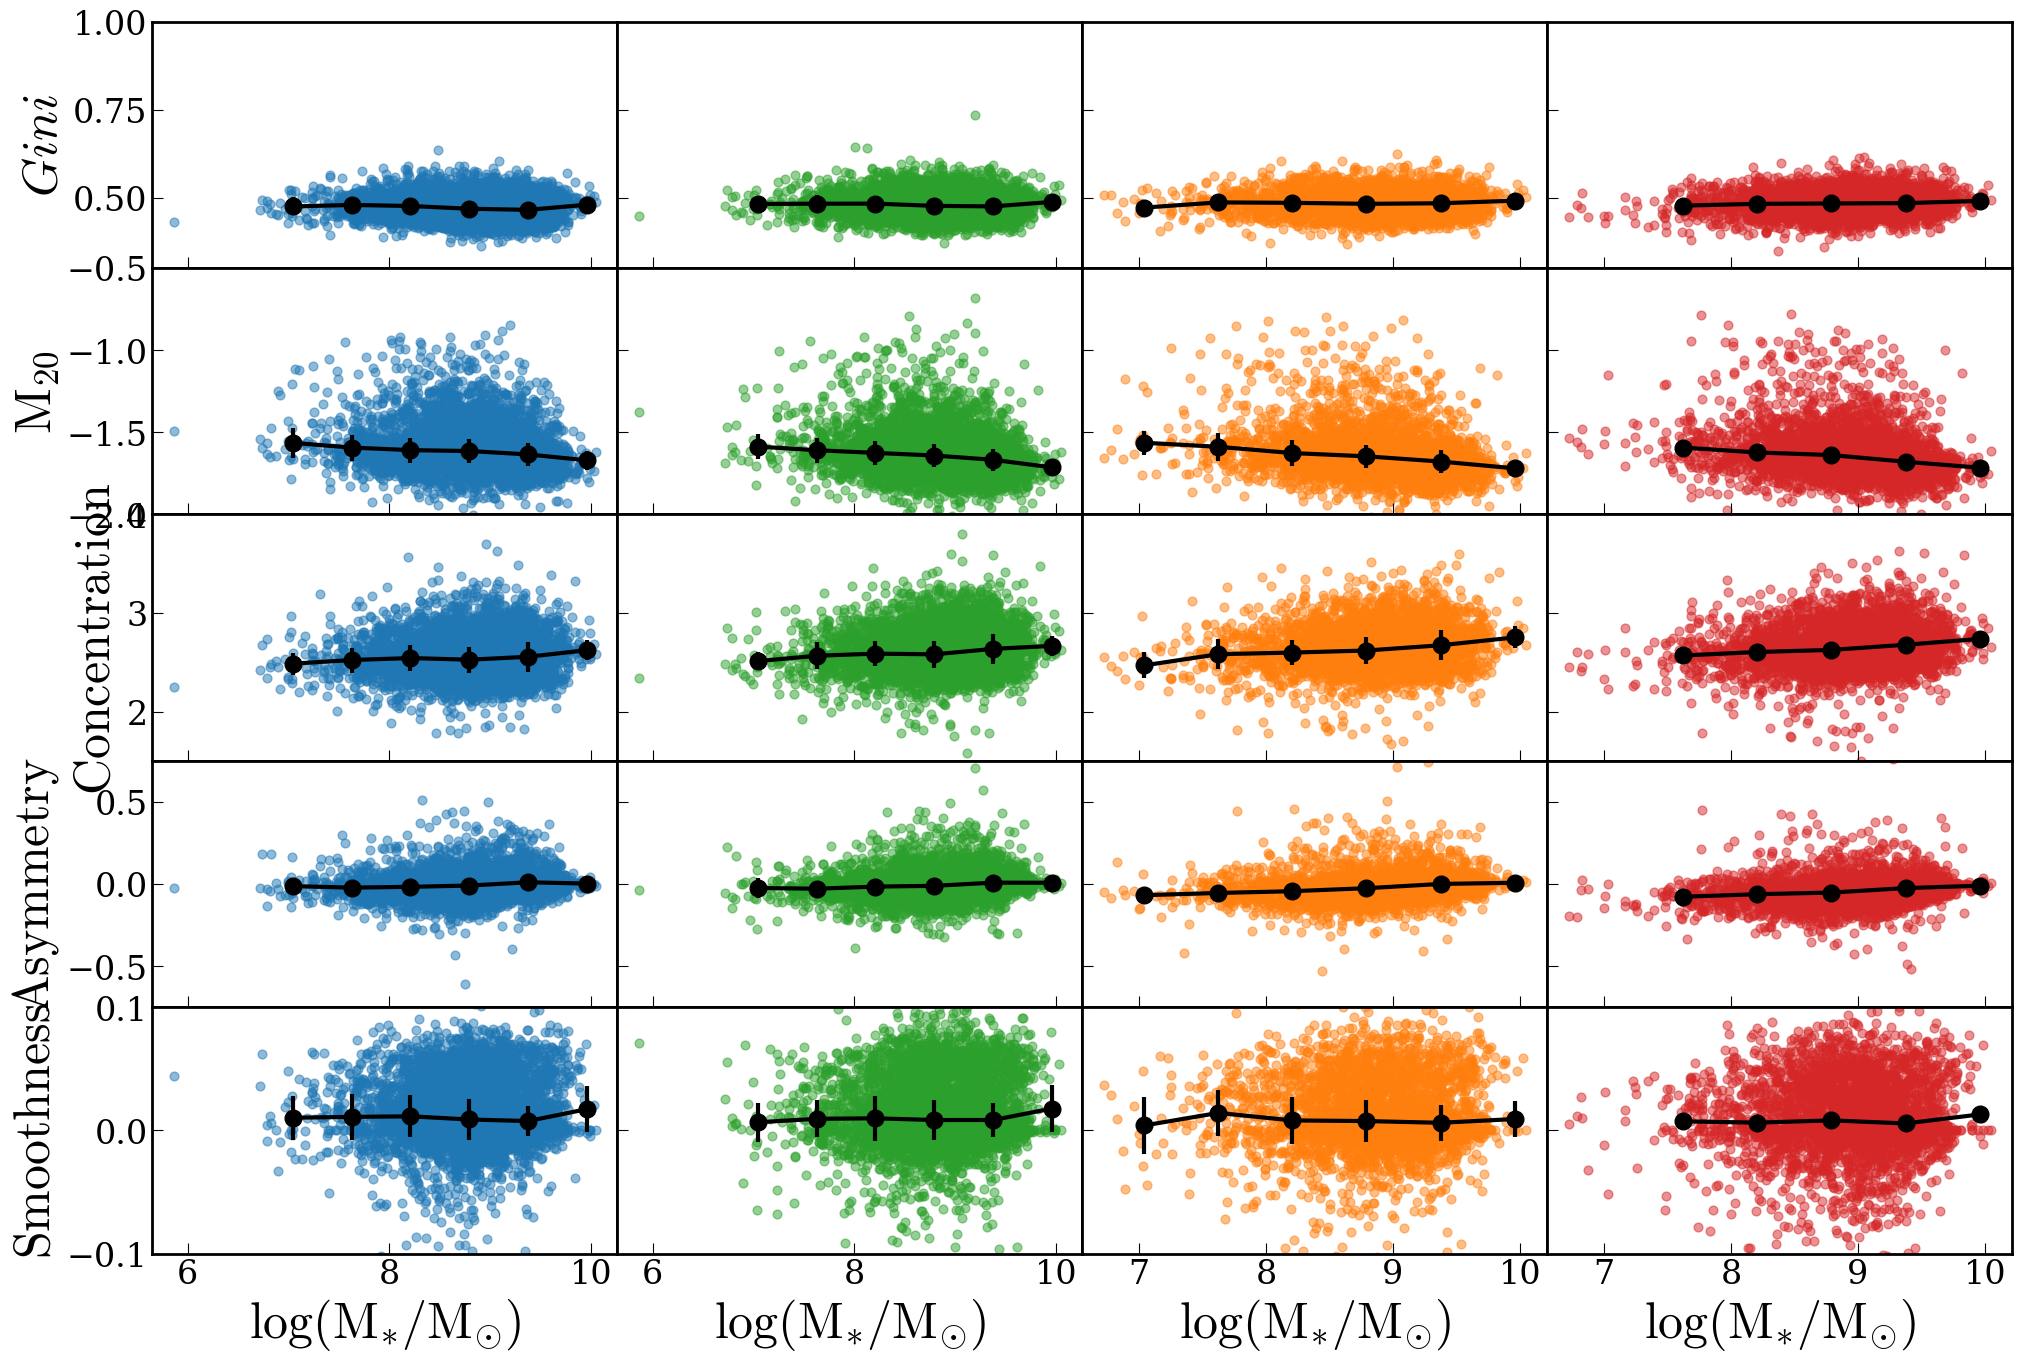

In [9]:
#high_snr = np.where(morph_all[:,0,1]<merger_line(morph_all[:,0,2]))[0]

fig1,ax1=plt.subplots(5,4,figsize=(24,16),sharey='row',sharex='col')

mst_arr = np.linspace(6.75,10.25,21)
mst_bins = np.linspace(6.75,10.25,7)
mst_bw = 0.5*(mst_bins[1]-mst_bins[0])
mst_arr +=  0.5*(mst_arr[1]-mst_arr[0]) 

morph_meds,morph_mads = np.zeros((2,5,4,20)),np.zeros((2,5,4,20))


zsp_arr = np.linspace(0,0.1,21)

#def linear(X,A):     return A[0]+A[1]*X[0]+A[2]*X[1]
#reg = linear_model.LinearRegression()

for i in range(4):
    #high_snr = np.where(morph_all[:,i,1]>merger_line(morph_all[:,i,2]))[0]
    selc = np.where((morph_all[:,i,9]==0)&(morph_all[:,i,10]>=2))[0]
    mst = sources['logM'].iloc[morph_all[selc,i,0]]


    #sersic = sources['reffr'].iloc[morph_all[high_snr,i,0]]
    for j,key in enumerate(param):
        ax1[j,i].scatter(mst,morph_all[selc,i,key],alpha=0.5,color=griz_col[i],s=40)
        ax1[j,i].set_ylim((param[key][0][0],param[key][0][1]))

        if i<3:
            bin_meds, bin_edges, binnumber = sts.binned_statistic(mst,morph_all[selc,i,key], statistic='median', bins=mst_bins)
            bin_mads, bin_edges, binnumber = sts.binned_statistic(mst,morph_all[selc,i,key], statistic=sts.median_abs_deviation, bins=mst_bins)

            ax1[j,i].errorbar(mst_bins[:-1]+mst_bw,bin_meds,yerr=bin_mads,color='black',marker='o',lw=3,markersize=12,elinewidth=3)

            cs = [CubicSpline(mst_bins[:-1]+mst_bw,bin_meds),CubicSpline(mst_bins[:-1]+mst_bw,bin_mads)]
    
            morph_meds[0,j,i,:],morph_mads[0,j,i,:] = cs[0](mst_arr[:-1]),cs[1](mst_arr[:-1])
        else:
            bin_meds, bin_edges, binnumber = sts.binned_statistic(mst,morph_all[selc,i,key], statistic='median', bins=mst_bins[1:])
            bin_mads, bin_edges, binnumber = sts.binned_statistic(mst,morph_all[selc,i,key], statistic=sts.median_abs_deviation, bins=mst_bins[1:])

            ax1[j,i].plot(mst_bins[1:-1]+mst_bw,bin_meds,color='black',marker='o',lw=3,markersize=12)

            cs = [CubicSpline(mst_bins[1:-1]+mst_bw,bin_meds),CubicSpline(mst_bins[1:-1]+mst_bw,bin_mads)]
    
            morph_meds[0,j,i,3:],morph_mads[0,j,i,3:] = cs[0](mst_arr[3:-1]),cs[1](mst_arr[3:-1])
            morph_meds[0,j,i,:3],morph_mads[0,j,i,:3] = np.nan,np.nan


        #reg.fit(np.column_stack((mst,zspec)), morph_all[high_snr,i,key])
        #p1=[reg.intercept_,*reg.coef_]
        #print(p1)

        #ax1[j,i].plot(mst_arr,linear([mst_arr,0.05],p1),lw=2,color='black')



    ax1[4,i].set_xlabel(r'${\rm log}(M_{\ast}/M_{\odot})$',fontsize=36)

ax1[0,0].set_ylabel( r'${\it Gini}$',fontsize=36)
ax1[1,0].set_ylabel(r'$M_{20}$',fontsize=36)
ax1[2,0].set_ylabel(r'$Concentration$',fontsize=36)
ax1[3,0].set_ylabel( r'$Asymmetry$',fontsize=36)
ax1[4,0].set_ylabel(r'$Smoothness$',fontsize=36)

plt.subplots_adjust(wspace=0.0,hspace=0.0)

#plt.savefig('NPdistributions2.pdf',bbox_inches='tight')

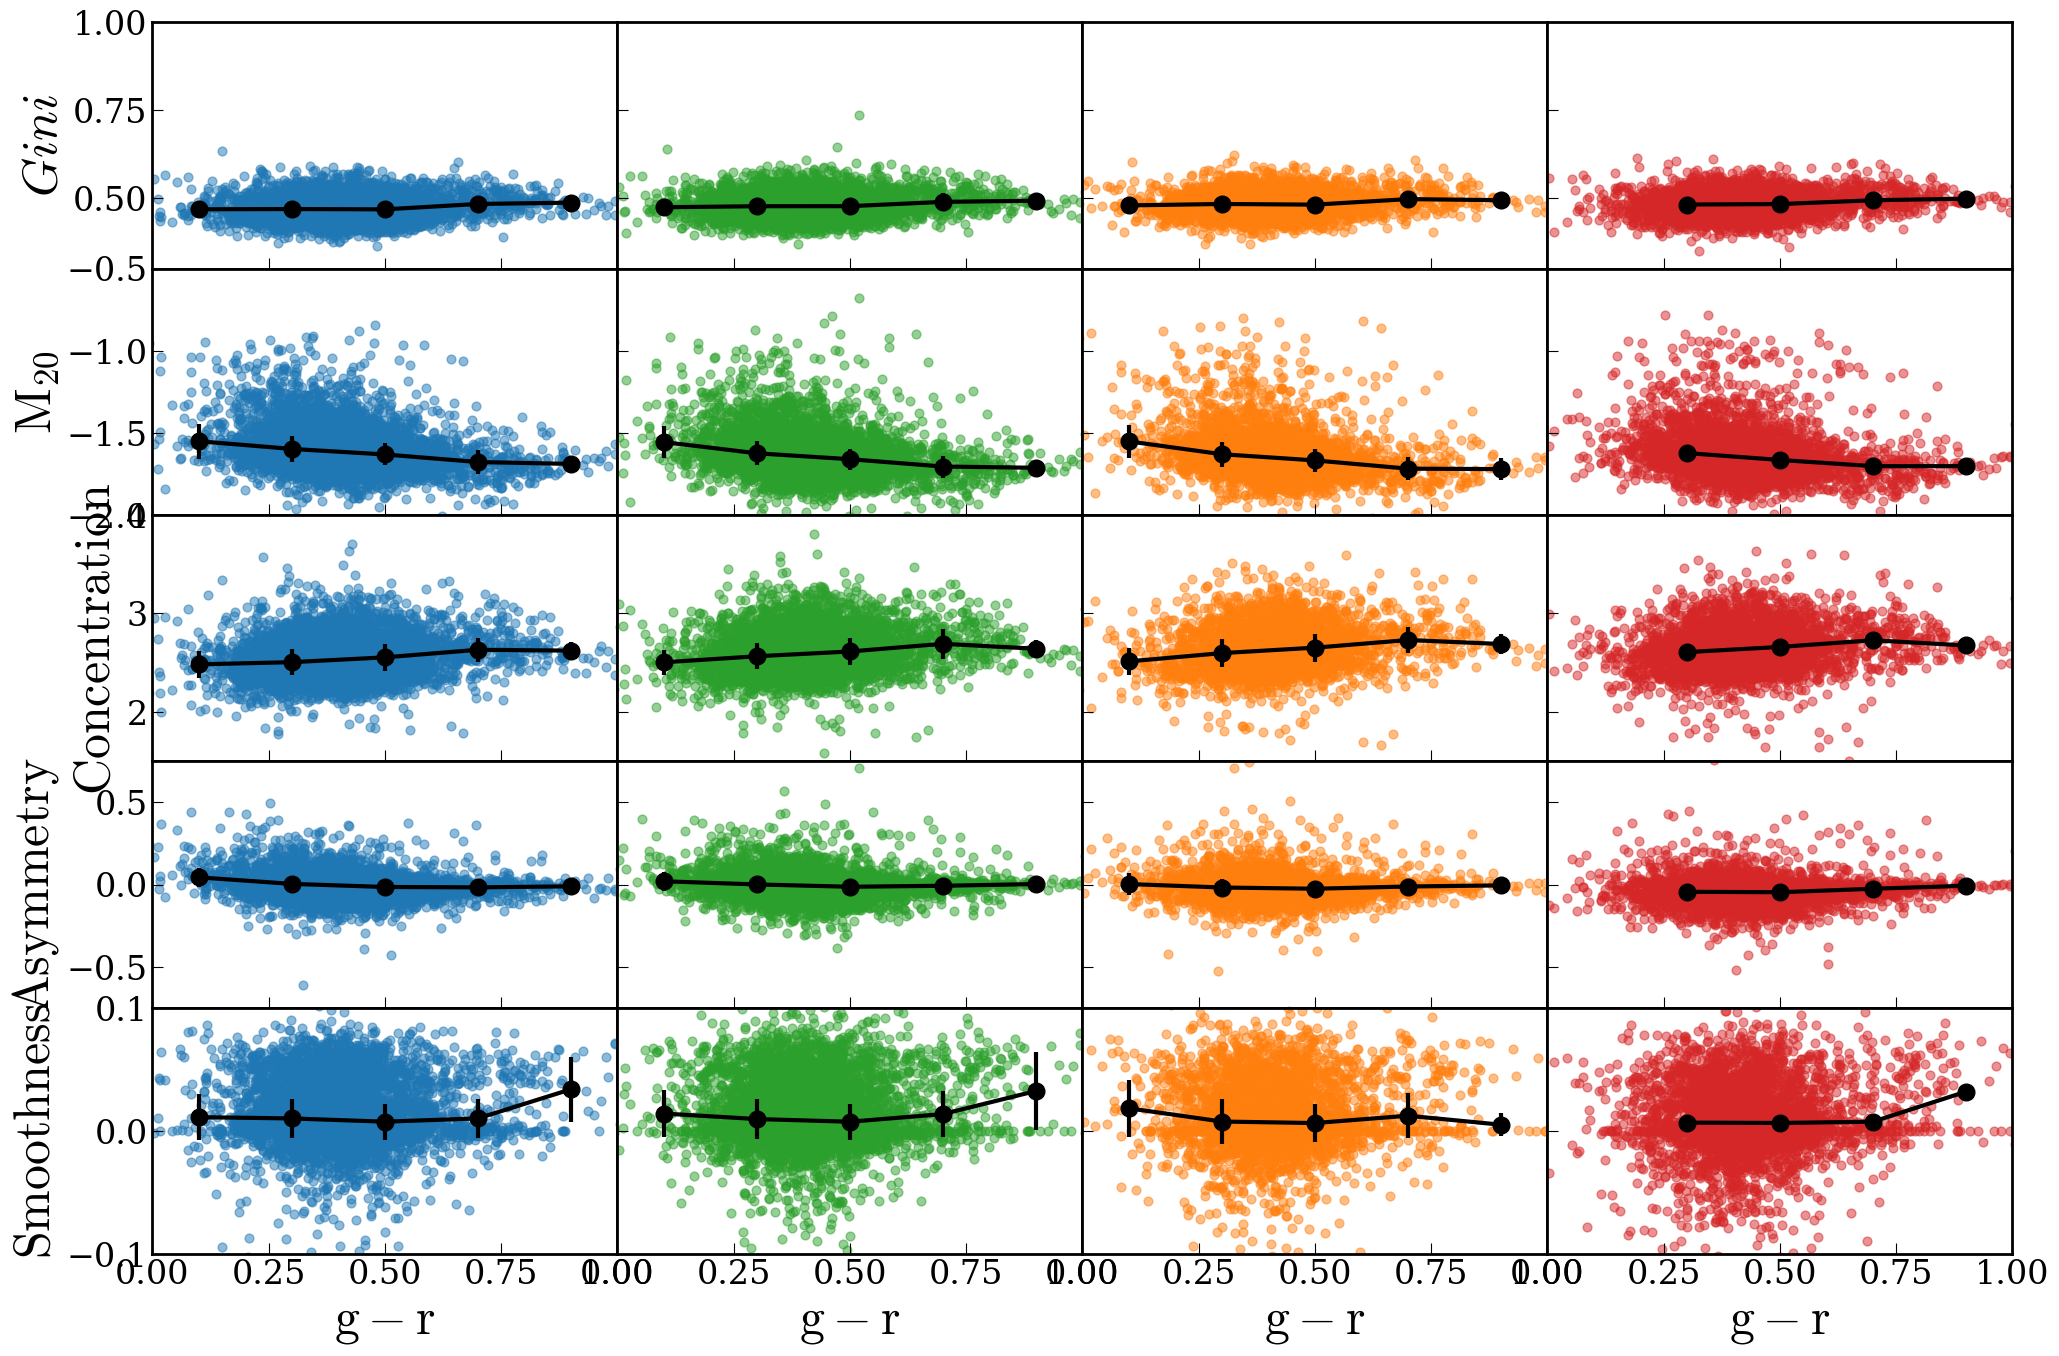

In [10]:
#high_snr = np.where(morph_all[:,0,1]<merger_line(morph_all[:,0,2]))[0]

fig1,ax1=plt.subplots(5,4,figsize=(24,16),sharey='row',sharex='col')

gr_arr = np.linspace(0,1,21)
gr_bins = np.linspace(0,1,6)
gr_bw = 0.5*(gr_bins[1]-gr_bins[0])
gr_arr +=  0.5*(gr_arr[1]-gr_arr[0]) 

#def linear(X,A):     return A[0]+A[1]*X[0]+A[2]*X[1]
#reg = linear_model.LinearRegression()

for i in range(4):
    #high_snr = np.where(morph_all[:,i,1]>merger_line(morph_all[:,i,2]))[0]
    selc = np.where((morph_all[:,i,9]==0)&(morph_all[:,i,10]>=2))[0]
    g_r = sources['g-r'].iloc[morph_all[selc,i,0]]

    #sersic = sources['reffr'].iloc[morph_all[high_snr,i,0]]
    for j,key in enumerate(param):
        ax1[j,i].scatter(g_r,morph_all[selc,i,key],alpha=0.5,color=griz_col[i],s=40)
        ax1[j,i].set_ylim((param[key][0][0],param[key][0][1]))

        if i<3:
            bin_meds, bin_edges, binnumber = sts.binned_statistic(g_r,morph_all[selc,i,key], statistic='median', bins=gr_bins)
            bin_mads, bin_edges, binnumber = sts.binned_statistic(g_r,morph_all[selc,i,key], statistic=sts.median_abs_deviation, bins=gr_bins)

            ax1[j,i].errorbar(gr_bins[:-1]+gr_bw,bin_meds,yerr=bin_mads,color='black',marker='o',lw=3,markersize=12,elinewidth=3)

            cs = [CubicSpline(gr_bins[:-1]+gr_bw,bin_meds),CubicSpline(gr_bins[:-1]+gr_bw,bin_mads)]
    
            morph_meds[1,j,i,:],morph_mads[1,j,i,:] = cs[0](gr_arr[:-1]),cs[1](gr_arr[:-1])
        else:
            bin_meds, bin_edges, binnumber = sts.binned_statistic(g_r,morph_all[selc,i,key], statistic='median', bins=gr_bins[1:])
            bin_mads, bin_edges, binnumber = sts.binned_statistic(g_r,morph_all[selc,i,key], statistic=sts.median_abs_deviation, bins=gr_bins[1:])

            ax1[j,i].plot(gr_bins[1:-1]+gr_bw,bin_meds,color='black',marker='o',lw=3,markersize=12)

            cs = [CubicSpline(gr_bins[1:-1]+gr_bw,bin_meds),CubicSpline(gr_bins[1:-1]+gr_bw,bin_mads)]
    
            morph_meds[1,j,i,3:],morph_mads[1,j,i,3:] = cs[0](gr_arr[3:-1]),cs[1](gr_arr[3:-1])
            morph_meds[1,j,i,:3],morph_mads[1,j,i,:3] = np.nan,np.nan

        #reg.fit(np.column_stack((mst,zspec)), morph_all[high_snr,i,key])
        #p1=[reg.intercept_,*reg.coef_]
        #print(p1)

        #ax1[j,i].plot(mst_arr,linear([mst_arr,0.05],p1),lw=2,color='black')


    ax1[4,i].set_xlim((0,1))
    ax1[4,i].set_xlabel(r'$g-r$',fontsize=36)

ax1[0,0].set_ylabel( r'${\it Gini}$',fontsize=36)
ax1[1,0].set_ylabel(r'$M_{20}$',fontsize=36)
ax1[2,0].set_ylabel(r'$Concentration$',fontsize=36)
ax1[3,0].set_ylabel( r'$Asymmetry$',fontsize=36)
ax1[4,0].set_ylabel(r'$Smoothness$',fontsize=36)

plt.subplots_adjust(wspace=0.0,hspace=0.0)

#plt.savefig('NPdistributions2.pdf',bbox_inches='tight')

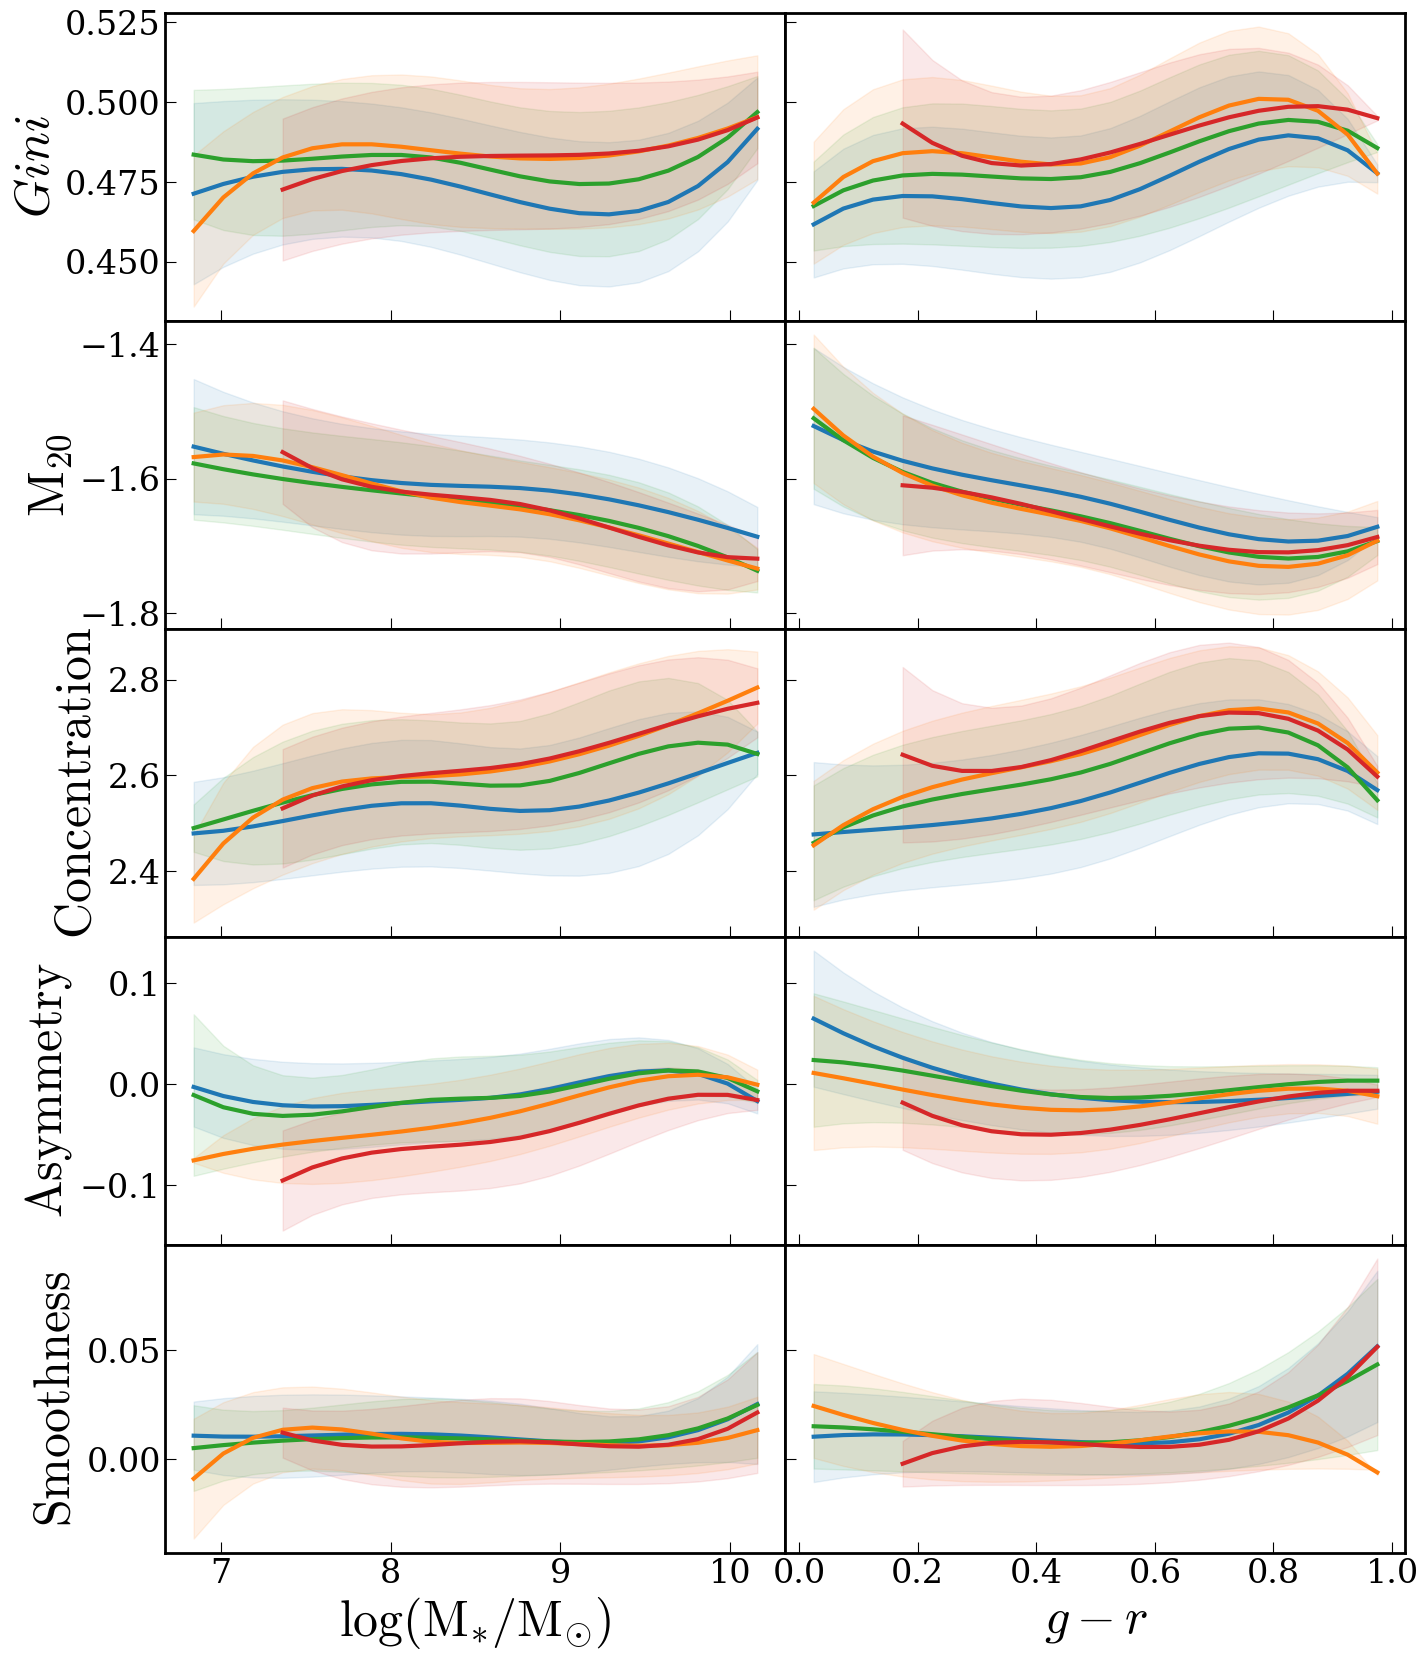

In [11]:
fig1,ax1=plt.subplots(5,2,figsize=(16,20),sharex='col',sharey='row')

for j,key in enumerate(param):
        for i,k in enumerate(channels):
            ax1[j,0].plot(mst_arr[:-1],morph_meds[0,j,i,:],color=griz_col[i],lw=3)
            ax1[j,0].fill_between(mst_arr[:-1],morph_meds[0,j,i,:]-morph_mads[0,j,i,:],morph_meds[0,j,i,:]+morph_mads[0,j,i,:],color=griz_col[i],alpha=0.1)

            ax1[j,1].plot(gr_arr[:-1],morph_meds[1,j,i,:],color=griz_col[i],lw=3)
            ax1[j,1].fill_between(gr_arr[:-1],morph_meds[1,j,i,:]-morph_mads[1,j,i,:],morph_meds[1,j,i,:]+morph_mads[1,j,i,:],color=griz_col[i],alpha=0.1)


ax1[-1,0].set_xlabel(r'${\rm log}(M_{\ast}/M_{\odot})$',fontsize=36)
ax1[-1,1].set_xlabel(r'${\it g-r}$',fontsize=36)

ax1[0,0].set_ylabel( r'${\it Gini}$',fontsize=36)
ax1[1,0].set_ylabel(r'$M_{20}$',fontsize=36)
ax1[2,0].set_ylabel(r'$Concentration$',fontsize=36)
ax1[3,0].set_ylabel( r'$Asymmetry$',fontsize=36)
ax1[4,0].set_ylabel(r'$Smoothness$',fontsize=36)

plt.subplots_adjust(wspace=0.0,hspace=0.0)

In [ ]:
#high_snr = np.where(morph_all[:,0,1]<merger_line(morph_all[:,0,2]))[0]

fig1,ax1=plt.subplots(5,4,figsize=(24,16),sharey='row',sharex='col')

mst_arr = np.linspace(6.5,10.5,21)
mst_bins = np.linspace(6.5,10.5,9)
mst_bw = 0.5*(mst_bins[1]-mst_bins[0])

zsp_arr = np.linspace(0,0.1,21)

def linear(X,A):     return A[0]+A[1]*X[0]+A[2]*X[1]
reg = linear_model.LinearRegression()

for i in range(4):
    #high_snr = np.where(morph_all[:,i,1]>merger_line(morph_all[:,i,2]))[0]

    #sersic = sources['reffr'].iloc[morph_all[high_snr,i,0]]
    for j,key in enumerate(npr):
        ax1[j,i].scatter(mst,morph_all[high_snr,i,key],alpha=0.5,color=griz_col[i],s=40)
        ax1[j,i].set_ylim((npr[key][0][0],npr[key][0][1]))

        bin_meds, bin_edges, binnumber = sts.binned_statistic(mst,morph_all[high_snr,i,key], statistic='median', bins=mst_bins)
        ax1[j,i].plot(mst_bins[:-1]+mst_bw,bin_meds,color='black',marker='o',lw=3,markersize=12)

        #reg.fit(np.column_stack((mst,zspec)), morph_all[high_snr,i,key])
        #p1=[reg.intercept_,*reg.coef_]
        #print(p1)

        #ax1[j,i].plot(mst_arr,linear([mst_arr,0.05],p1),lw=2,color='black')



    ax1[4,i].set_xlabel(r'${\rm log}(M_{\ast}/M_{\odot})$',fontsize=36)

ax1[0,0].set_ylabel( r'${\it Gini}$',fontsize=36)
ax1[1,0].set_ylabel(r'$M_{20}$',fontsize=36)
ax1[2,0].set_ylabel(r'$Concentration$',fontsize=36)
ax1[3,0].set_ylabel( r'$Asymmetry$',fontsize=36)
ax1[4,0].set_ylabel(r'$Smoothness$',fontsize=36)

plt.subplots_adjust(wspace=0.0,hspace=0.0)

#plt.savefig('NPdistributions2.pdf',bbox_inches='tight')

KeyError: 'logD'

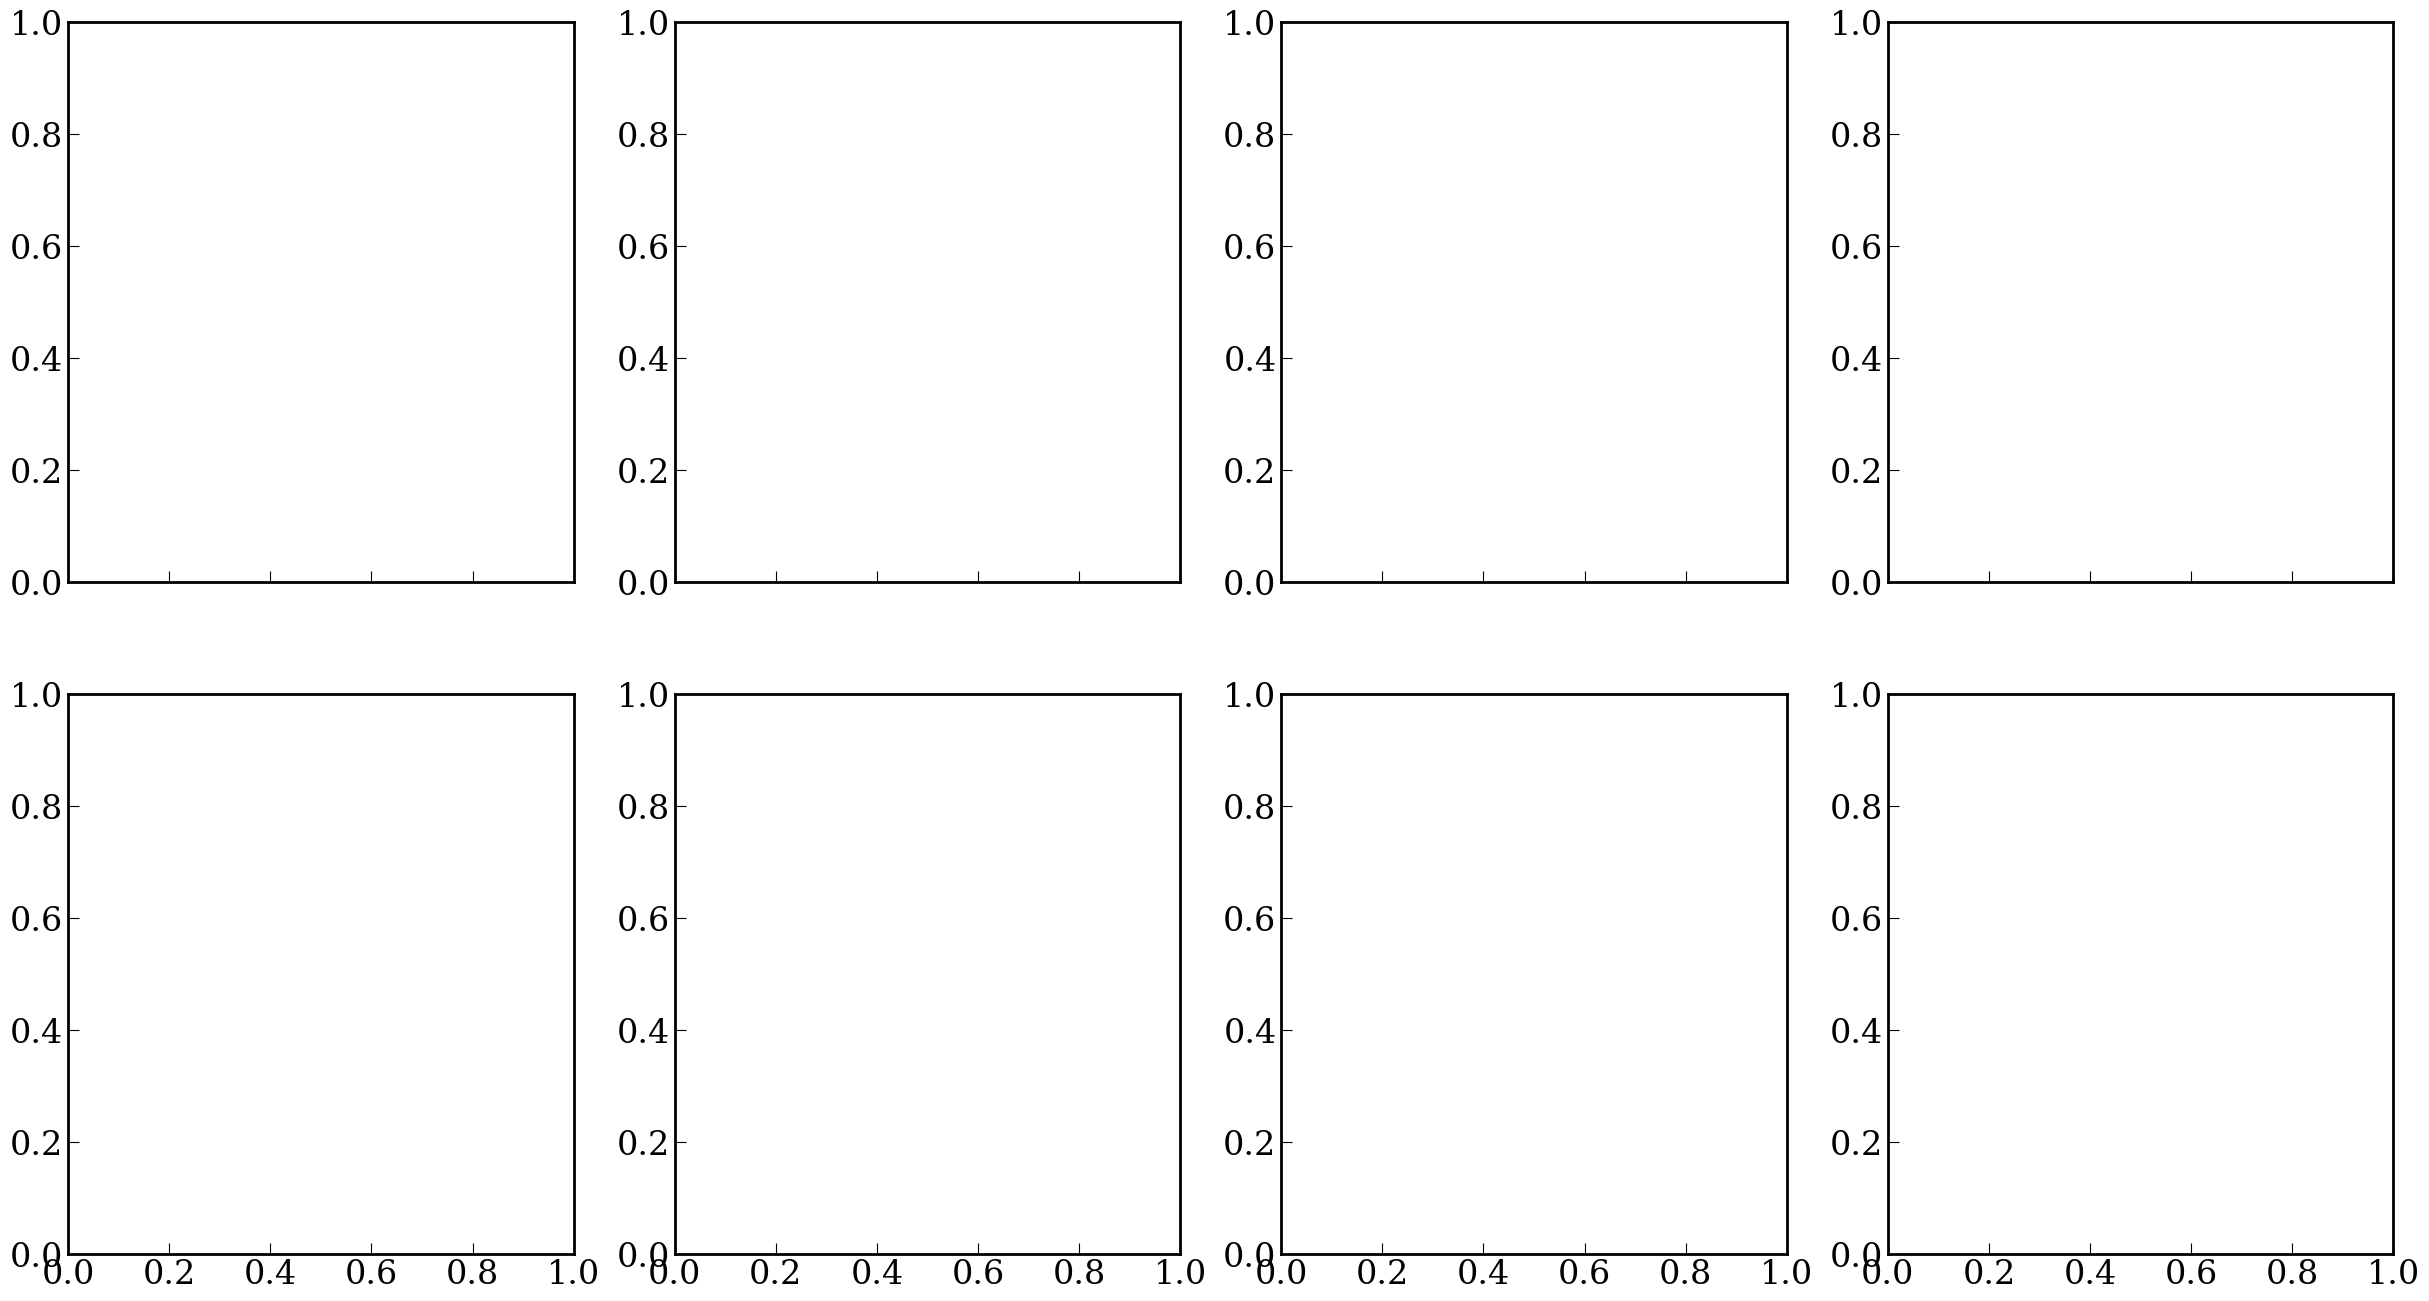

In [32]:
fig,ax=plt.subplots(2,4,figsize=(30,16),sharex='col')

griz_col = ['tab:blue','tab:green','tab:orange','tab:red']

for i in range(4):
    #print(morph_arr[:,-1])
    dst = sources['logD'].iloc[morph_all[:,i,0]]
    
    ax[0,i].scatter(np.power(10,dst),morph_all[:,i,9],alpha=0.4,color=griz_col[i],s=40)
    ax[1,i].scatter(np.power(10,dst),morph_all[:,i,10],alpha=0.4,color=griz_col[i],s=40)

    ax[1,i].set_xlabel(r'$D\ (Mpc)$',fontsize=36)

fig,ax=plt.subplots(2,4,figsize=(30,16),sharex='col')

griz_col = ['tab:blue','tab:green','tab:orange','tab:red']

for i in range(4):
    #print(morph_arr[:,-1])
    dst = sources['logM'].iloc[morph_all[:,i,0]]
    
    ax[0,i].scatter(dst,morph_all[:,i,9],alpha=0.4,color=griz_col[i],s=40)
    ax[1,i].scatter(dst,morph_all[:,i,10],alpha=0.4,color=griz_col[i],s=40)

    ax[1,i].set_xlabel(r'${\rm log}(M/M_{\odot})$',fontsize=36)


In [ ]:
from scipy.interpolate import RectBivariateSpline as RBS

def get_star_psf(ns_pos):
        ns_coord = SkyCoord(ra=ns_pos[0]*u.degree, dec=ns_pos[1]*u.degree, frame='icrs')

        download_cutout(ns_pos.reshape(1,2),size=32,out_dir='bright_stars/')
        star_dat = fits.open('bright_stars/cutout_{:.4f}_{:.4f}.fits'.format(ns_pos[0],ns_pos[1]))
        star_arr = star_dat[0].data
        star_hdr = star_dat[0].header

        nw = wcs.WCS(star_hdr,naxis=2)
        nsp2 = [int(i) for i in nw.world_to_pixel(ns_coord)]
        d_psf = 6 # in pixels, the size of the cutout
        
        star_data,star_hdr,star_rms,glob_rms = image_bkg(star_dat[0])
        
        fig,ax=plt.subplots(1,4,figsize=(24,8),sharey='row')
        #fig = plt.figure(figsize=(6*len(c),14)) 
        
        psfs = []
        for jj,ley in enumerate(channels):
            if np.any(star_data[jj]>0):
                #image_plot(ax[ii],star_arr[ii,:,:],channels[key])
            
                objects = sep.extract(star_data[jj], 5, err=star_rms[jj])
                target = np.argmin(np.sqrt((objects['x']-nsp2[0])**2+(objects['y']-nsp2[1])**2))
            
                #ax[ii].scatter(objects['x'][target],objects['y'][target],marker='*',color='red',s=50)
                nsp2[0],nsp2[1] = objects['x'][target],objects['y'][target]
                
                model = star_data[jj][(round(nsp2[1])-d_psf):(round(nsp2[1])+d_psf+1), (round(nsp2[0])-d_psf):(round(nsp2[0])+d_psf+1)]
                model = np.copy(model)
            
                # now we center the psf model via interpolation
                x = np.arange(-d_psf, d_psf+1)
                y = np.arange(-d_psf, d_psf+1)
                model_interp = RBS(y, x, model)
            
                xcen = nsp2[0] - round(nsp2[0])
                ycen = nsp2[1] - round(nsp2[1])
            
                xi = np.arange(xcen-d_psf+1, xcen+d_psf)
                yi = np.arange(ycen-d_psf+1, ycen+d_psf)
            
                model_2 = model_interp(yi, xi)
                model_2 /= np.sum(model_2)
            
                image_plot(ax[jj],model_2,channels[ley])
            
                psfs.append(model_2)
